# Jupyter with PostgreSQL

## Libararies and Settings

In [61]:
# Libraries
import os
import re
import requests
import json
import urllib
import psycopg2
import pandas as pd
import numpy as np
import folium
from sqlalchemy import create_engine
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2
from scipy.stats import chi2_contingency

# Settings
import warnings
warnings.filterwarnings("ignore")

# Current working directory
print(os.getcwd())

/


## Create database connection

In [2]:
conn = psycopg2.connect("host=localhost dbname=app user=app_user password=app_password")

## Read data

In [3]:
df = pd.read_csv('/workspace/Tutti.csv', sep=',')
df.head(5)

,web-scraper-order,web-scraper-start-url,location_date,brand_type,price
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3'900.-
1,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5'990.-
2,1703597180-3,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Thurgau, 8370, 26.06.2018, auf autoscout24.ch",LANCIA Dedra 2.0 HF Integrale,6'950.-
3,1703597180-4,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Bern, 3604, 04.06.2018, auf autoscout24.ch",LANCIA BETA 2000 Spider,19'990.-
4,1703597180-5,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Bern, 4943, 04.04.2018, auf autoscout24.ch",VW Polo 1300 C (X),12'900.-


## Count number of rows and columns in the data frame

In [4]:
# Dimension (rows, columns)
print('Dimension:', df.shape)

# Number of rows
print('Number of rows:', df.shape[0])

# Number of columns
print('Number of columns:', df.shape[1])

Dimension: (2804, 5)
Number of rows: 2804
Number of columns: 5


## Extract and save relevant information from raw data using regular expressions (regex)

### Extract Canton

In [5]:
# Extrahiere das erste Wort vor dem Komma in den Strings der 'location_date' Spalte
cantons = []
for i in df['location_date']:
    split_string = i.split(',')[0].strip()  # Teilt den String am Komma und nimmt den ersten Teil
    cantons.append(split_string)

# Speichere als neue Variable im Pandas DataFrame
df['canton'] = cantons

# Gib die ersten 5 Werte aus
print(df['location_date'].head(5), '\n')
print(df['canton'].head(5))

0      Waadt, 1026, 03.10.2018, auf autoscout24.ch
1     Aargau, 5054, 08.09.2018, auf autoscout24.ch
2    Thurgau, 8370, 26.06.2018, auf autoscout24.ch
3       Bern, 3604, 04.06.2018, auf autoscout24.ch
4       Bern, 4943, 04.04.2018, auf autoscout24.ch
Name: location_date, dtype: object 

0      Waadt
1     Aargau
2    Thurgau
3       Bern
4       Bern
Name: canton, dtype: object


### Extract PLZ

In [6]:

# Extrahiere die PLZ, die nach dem ersten und vor dem zweiten Komma kommt
plz_list = []
for i in df['location_date']:
    parts = i.split(',')
    try:
        plz = parts[1].strip()  # Wählt den zweiten Teil nach dem Split, der die PLZ enthält
    except IndexError:
        plz = None  # Falls weniger als 2 Kommas vorhanden sind
    plz_list.append(plz)

# Speichere als neue Variable im Pandas DataFrame
df['plz'] = plz_list

df = df[df['plz'].apply(lambda x: len(str(x)) == 4)]

try:
    df['plz'] = df['plz'].astype('int64')
except ValueError:
    print("Konvertierung fehlgeschlagen: Die Spalte enthält ungültige oder fehlende Werte.")

# Gib die ersten 5 Werte aus
print(df['location_date'].head(5), '\n')
print(df['plz'].head(5))


0      Waadt, 1026, 03.10.2018, auf autoscout24.ch
1     Aargau, 5054, 08.09.2018, auf autoscout24.ch
2    Thurgau, 8370, 26.06.2018, auf autoscout24.ch
3       Bern, 3604, 04.06.2018, auf autoscout24.ch
4       Bern, 4943, 04.04.2018, auf autoscout24.ch
Name: location_date, dtype: object 

0    1026
1    5054
2    8370
3    3604
4    4943
Name: plz, dtype: int64


### Remove .- in the price and set the type to float

In [7]:
df['price'] = df['price'].str.replace("'", "")  # Entfernt Apostroph (Tausendertrennzeichen)

# Kann nur einmal ausgeführt werden, da der Typ nur einmalig geändert werden kann! Sonst benötigt es einen neuen "Alle Ausführen".
df['price'] = df['price'].replace({r'\.-$': ''}, regex=True).astype(float) 
df['price'].head()

0     3900.0
1     5990.0
2     6950.0
3    19990.0
4    12900.0
Name: price, dtype: float64

In [8]:
df.dtypes

web-scraper-order         object
web-scraper-start-url     object
location_date             object
brand_type                object
price                    float64
canton                    object
plz                        int64
dtype: object

## Count and identify missing values (if any)

In [9]:
# Count missing values
print(pd.isna(df).sum())

# Identify rows with missing values
df[df.isna().any(axis=1)].head()

web-scraper-order        0
web-scraper-start-url    0
location_date            0
brand_type               0
price                    0
canton                   0
plz                      0
dtype: int64


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz


### Count and identify dublicates

In [10]:
# Count duplicated values
print(df.duplicated().sum())

# Identify rows with duplicated values, e.g.:
df[df[['web-scraper-order', 'location_date', 'brand_type']].duplicated()]

0


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz


In [11]:
# Geocoded data (i.e. data with latitude and longitude)
df_geo = pd.read_csv('/workspace/PLZ_Ortschaft_BFSNummer.csv', 
                     sep=';', 
                     encoding='utf-8')

# Rename columns
df_geo = df_geo.rename(columns={'Gemeindename':'ort',
                                'BFS-Nr':'bfs_number', 
                                'PLZ':'plz'})

# Show data
df_geo[['ort', 
        'bfs_number', 
        'plz']].head()

,ort,bfs_number,plz
0,Aeugst am Albis,1,8914
1,Aeugst am Albis,1,8914
2,Affoltern am Albis,2,8909
3,Affoltern am Albis,2,8910
4,Bonstetten,3,8906


### Join informations

In [12]:
# Entfernen von Duplikaten in df_geo basierend auf 'plz', wobei nur der erste Eintrag behalten wird
df_geo_unique = df_geo.drop_duplicates(subset='plz', keep='first')

# Zusammenführen von df mit dem modifizierten df_geo
df2 = df.merge(df_geo_unique[['ort', 'bfs_number', 'plz']], on='plz')

# Anzeigen der ersten 10 Zeilen
df2.head(10)


,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz,ort,bfs_number
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632
1,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275
2,1703597192-34,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 16.03.2020, auf autoscout24.ch",MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275
3,1703597214-95,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 02.03.2022, auf Autoscout24.ch",ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275
4,1703597226-129,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 02.07.2022, auf Autoscout24.ch",CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275
5,1703597249-175,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 19.11.2022, auf Autoscout24.ch",ROVER 827 Vitesse,3990.0,Aargau,5054,Kirchleerau,4275
6,1703597482-792,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 02.11.2023",Mini Morris 850,24200.0,Aargau,5054,Kirchleerau,4275
7,1703597586-1047,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 09.11.2023",VW Bus T3 Typ 2 (Militärbus) Camperbus,13000.0,Aargau,5054,Kirchleerau,4275
8,1703597180-3,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Thurgau, 8370, 26.06.2018, auf autoscout24.ch",LANCIA Dedra 2.0 HF Integrale,6950.0,Thurgau,8370,Eschlikon,4724
9,1703597180-14,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Thurgau, 8370, 07.05.2013, auf autoscout24.ch",CITROEN 2CV6 Spécial (Club),4800.0,Thurgau,8370,Eschlikon,4724


## Add municipalities

In [13]:
df_municip = pd.read_excel('/workspace/municipality_data (1).xlsx', 
                           sheet_name='data_for_import')
df_municip.head(5)

,bfs_number,bfs_name,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,1,Aeugst am Albis,1981,250.442478,14.184755,442.0,105013.570634
1,2,Affoltern am Albis,12303,1161.756374,28.700317,6920.0,71059.805603
2,3,Bonstetten,5572,749.932705,16.564968,1014.0,88927.698145
3,4,Hausen am Albis,3751,275.808824,16.022394,1021.0,86300.455137
4,5,Hedingen,3778,578.560490,16.410799,1478.0,90811.205330


In [14]:
# Merge needs a key which must be identical in both data sets (here the key is 'bfs_number')
df3 = df2.merge(df_municip[['bfs_number', 
                            'pop', 
                            'pop_dens', 
                            'frg_pct', 
                            'emp',
                            'mean_taxable_income']], 
                on="bfs_number")
df3.head(5)

,web-scraper-order,web-scraper-start-url,location_date,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,1703597180-1,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Waadt, 1026, 03.10.2018, auf autoscout24.ch",LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,1703597180-2,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 08.09.2018, auf autoscout24.ch",VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,1703597192-34,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 16.03.2020, auf autoscout24.ch",MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,1703597214-95,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 02.03.2022, auf Autoscout24.ch",ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,1703597226-129,https://www.tutti.ch/de/q/autos/Ak8CkY2Fyc5TAk...,"Aargau, 5054, 02.07.2022, auf Autoscout24.ch",CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Calculate some mean Prices for Car Types

In [15]:
# Using pivot_table to reshape the data and calculate means 
pd.pivot_table(df3[['brand_type', 'price']],
               index=['brand_type'],
               values=['price', 'brand_type'],
               aggfunc=(np.mean))

,price
brand_type,
"'53 Mercury, '60 Pontiac, '79 Chevy in blocco o singole",50000.0
"'72 Ford Ranchero 500 ""survivor""",28500.0
'91 Pontiac TransAm T.-Top option WS6 expertisée du jour,7900.0
** Ford Fiesta 1.3i / 60'000 km !!**,6900.0
** Mercedes-Benz 250 ** Veteran,19900.0
...,...
zu verkaufen,37250.0
zu verkaufen Oldtimer Triumph Spitfire IV Gabriolet,19800.0
zuverkaufen top zustand 2700 fr km 86000,2200.0


In [16]:
df4 = df3.drop(columns=['web-scraper-order', 'web-scraper-start-url', 'location_date'])
df4.head(5)

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Removal of not used webscraper data

In [17]:
df4 = df3.drop(columns=['web-scraper-order','web-scraper-start-url','location_date'])

df4.head(5)

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


## Write data to database

In [18]:
engine = create_engine('postgresql://app_user:app_password@db:5432/app')
df4.to_sql('car_table', engine, if_exists='replace')

734

## SQL querys

In [19]:
df_sub = pd.read_sql_query('''SELECT
                            brand_type,
                            price,
                            canton,
                            plz,
                            ort,
                            bfs_number,
                            pop,
                            pop_dens,
                            frg_pct,
                            emp,
                            mean_taxable_income
                            FROM car_table''', 
                            con=engine)
df_sub.head()

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Count amount of entries per canton with a salary over 75'000

In [20]:
df_count = pd.read_sql_query('''SELECT canton, COUNT(*) AS GesamtEintraege
                            FROM car_table
                            WHERE mean_taxable_income > 75000
                            GROUP BY canton
                            ORDER BY GesamtEintraege DESC;''',
                            con=engine)
df_count.head()

,canton,gesamteintraege
0,Zürich,271
1,Tessin,71
2,Basel-Landschaft,55
3,Aargau,52
4,Zug,50


In [21]:
df_avg_price = pd.read_sql_query('''SELECT brand_type, ROUND(CAST(AVG(price) AS numeric), 2) AS average_price
                                FROM car_table
                                GROUP BY brand_type;
                                ;''',
                                con=engine)

df_avg_price.head()


,brand_type,average_price
0,Ford USA Mustang V8 351 Cabriolet,17500.0
1,Jaguar XJ 3.4 Jg. 1976 grün - Oldtimer,8500.0
2,TOYOTA Celica 2000 GTi,7900.0
3,1988 BMW e30 320i,13000.0
4,Buick Skylark Veteran,5500.0


### Reshapping data 

In [22]:
df_shaped = df_sub[['ort', 'brand_type', 'price', 'canton']][:5]
print('Original shape')
print(df_shaped, '\n')

df_shaped_stacked = df_shaped.stack()
print('Stacked')
print(df_shaped_stacked, '\n')

# Using unstack
print('Unstacked (= back to original shape)')
print(df_shaped_stacked.unstack())

Original shape
           ort                   brand_type   price  canton
0       Denges     LANCIA Dedra 2.0 i.e. LX  3900.0   Waadt
1  Kirchleerau     VW Golf 1800 S-Plus (GL)  5990.0  Aargau
2  Kirchleerau   MITSUBISHI Colt 1400 GLX A  5990.0  Aargau
3  Kirchleerau          ROVER 827 Vitesse A  6990.0  Aargau
4  Kirchleerau  CHEVROLET Corsica 3.1 V6 LT  4990.0  Aargau 

Stacked
0  ort                                Denges
   brand_type       LANCIA Dedra 2.0 i.e. LX
   price                              3900.0
   canton                              Waadt
1  ort                           Kirchleerau
   brand_type       VW Golf 1800 S-Plus (GL)
   price                              5990.0
   canton                             Aargau
2  ort                           Kirchleerau
   brand_type     MITSUBISHI Colt 1400 GLX A
   price                              5990.0
   canton                             Aargau
3  ort                           Kirchleerau
   brand_type            ROVER

In [23]:
df_sub_melt = df_sub[['brand_type', 'price', 'canton']][:5]
print('Original shape')
print(df_sub_melt, '\n')

print('Reshaped using .melt()')
print(pd.melt(df, id_vars=['brand_type'], value_vars=['price', 'canton']))

Original shape
                    brand_type   price  canton
0     LANCIA Dedra 2.0 i.e. LX  3900.0   Waadt
1     VW Golf 1800 S-Plus (GL)  5990.0  Aargau
2   MITSUBISHI Colt 1400 GLX A  5990.0  Aargau
3          ROVER 827 Vitesse A  6990.0  Aargau
4  CHEVROLET Corsica 3.1 V6 LT  4990.0  Aargau 

Reshaped using .melt()
                                             brand_type variable     value
0                              LANCIA Dedra 2.0 i.e. LX    price    3900.0
1                              VW Golf 1800 S-Plus (GL)    price    5990.0
2                         LANCIA Dedra 2.0 HF Integrale    price    6950.0
3                               LANCIA BETA 2000 Spider    price   19990.0
4                                    VW Polo 1300 C (X)    price   12900.0
...                                                 ...      ...       ...
5593                2CV Super mit Wohnwagen und Vorzelt   canton    Zürich
5594  Chevrolet Corvette Stingray Cabriolet Oldtimer...   canton   Thurgau
559

# 4 Non-graphical and graphical exploratory data analysis (EDA)

### Importing the enriched oldtimer data

In [24]:
df_orig = pd.read_sql_query('''SELECT
                            brand_type,
                            price,
                            canton,
                            plz,
                            ort,
                            bfs_number,
                            pop,
                            pop_dens,
                            frg_pct,
                            emp,
                            mean_taxable_income
                            FROM car_table''', 
                            con=engine)

# Remove duplicates
df_orig = df_orig.drop_duplicates()
df_orig.head(5)

# Remove missing values
df_orig = df_orig.dropna()
df_orig.head(5)

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Quantiles original values

In [25]:
df_orig[['price', 'pop_dens']].quantile(q=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).round(2)

,price,pop_dens
0.05,2000.0,57.64
0.10,3500.0,96.54
0.25,6900.0,173.60
0.50,14599.5,448.61
0.75,24875.0,1030.37
0.90,39250.0,1915.76
0.95,58000.0,2851.44
0.99,100000.0,4778.99


### Filter oldtimers

In [26]:
df_filtered = df_orig.loc[df_orig['pop_dens'] <= 5000]

df_filtered.head()

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
0,LANCIA Dedra 2.0 i.e. LX,3900.0,Waadt,1026,Denges,5632,1608,968.674699,29.228856,895.0,84307.739938
1,VW Golf 1800 S-Plus (GL),5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
2,MITSUBISHI Colt 1400 GLX A,5990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
3,ROVER 827 Vitesse A,6990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000
4,CHEVROLET Corsica 3.1 V6 LT,4990.0,Aargau,5054,Kirchleerau,4275,870,199.541284,10.689655,259.0,60049.000000


### Shape (number of rows and colums)

In [27]:
print(df_filtered.shape)

(2624, 11)


### Data types

In [28]:
df_filtered.dtypes

brand_type              object
price                  float64
canton                  object
plz                      int64
ort                     object
bfs_number               int64
pop                      int64
pop_dens               float64
frg_pct                float64
emp                    float64
mean_taxable_income    float64
dtype: object

### Summary statistics of numeric variables

In [29]:
df_filtered.describe()

,price,plz,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
count,2624.000000,2624.000000,2624.00000,2624.000000,2624.000000,2624.000000,2624.000000,2624.000000
mean,19480.919588,6188.266006,2577.48628,19460.456555,774.168811,21.100628,18021.292683,72954.521336
std,20225.867640,2384.947397,1957.98792,58272.867633,912.737481,9.900443,68127.407763,19573.988894
min,100.000000,1000.000000,1.00000,161.000000,2.606078,1.647446,20.000000,42230.717300
25%,6900.000000,4410.000000,608.00000,2194.000000,171.874898,13.475919,780.250000,63569.927536
50%,14600.000000,6417.000000,2556.00000,4971.000000,439.967105,20.029587,2116.000000,68464.601333
75%,24800.000000,8380.500000,4197.50000,12908.250000,1009.259259,27.023443,6871.000000,76953.437739
max,180000.000000,9657.000000,6809.00000,420217.000000,4778.994655,50.269374,491193.000000,229181.911653


### Summary statistics of numeric variables without outliers

In [30]:
# Define the criteria for filtering
min_price = 100
max_price = 125000

# Create a subset of the DataFrame without outliers
filtered_df = df_filtered.loc[
    (df_filtered['price'] >= min_price) & (df_filtered['price'] <= max_price)
]

# Display the first few rows of the filtered DataFrame
filtered_df.describe()

,price,plz,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
count,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000,2612.000000
mean,18858.397014,6185.513783,2577.890888,19499.702527,771.660180,21.082794,18071.814319,72859.876461
std,18017.138765,2385.805848,1958.137053,58400.498340,911.371848,9.913398,68277.087657,19393.510467
min,100.000000,1000.000000,1.000000,161.000000,2.606078,1.647446,20.000000,42230.717300
25%,6900.000000,4410.000000,608.000000,2194.000000,168.263800,13.379310,775.000000,63488.370188
50%,14500.000000,6417.000000,2563.500000,4925.000000,436.513158,19.978461,2114.000000,68356.142765
75%,24500.000000,8370.000000,4199.250000,12908.250000,1009.259259,26.895226,6871.000000,76953.437739
max,125000.000000,9657.000000,6809.000000,420217.000000,4778.994655,50.269374,491193.000000,229181.911653


### Statistical measures (min, max, std, mean, median, count) for price

In [31]:
print('Price:',
      'Count:', round(df_filtered.price.count(), 1),
      'Min:', round(df_filtered.price.min(), 1),
      'Max:', round(df_filtered.price.max(), 1),
      'Mean:', round(df_filtered.price.mean(), 1),
      'Median:', round(df_filtered.price.median(), 1),
      'Std:', round(df_filtered.price.std(), 1))

Price: Count: 2624 Min: 100.0 Max: 180000.0 Mean: 19480.9 Median: 14600.0 Std: 20225.9


### Skewness

In [32]:
df_filtered['price'].skew()

3.0314503928315144

### Kurtosis

In [33]:
df_filtered['price'].kurtosis()

13.479398235328823

### Extreme values

In [34]:
# Low costs oldtimers
df_filtered[df_filtered['price'] <= 200]

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
1668,De Tomaso Mangusta,150.0,Zürich,8803,Kilchberg (ZH),135,8923,3458.527132,32.858904,4127.0,166467.202970
1669,Ferrari 512 S,150.0,Zürich,8803,Kilchberg (ZH),135,8923,3458.527132,32.858904,4127.0,166467.202970
1685,"VOLVO 850 (1st Gen.) SCHLACHTFEST, TEILE, PEZZI",100.0,Tessin,6516,Locarno,5113,15776,844.087747,34.248225,13188.0,58270.380018


In [35]:
# Very expensive oldtimers
df_filtered[df_filtered['price'] >= 150000]

,brand_type,price,canton,plz,ort,bfs_number,pop,pop_dens,frg_pct,emp,mean_taxable_income
389,Lancia Aurelia B20 GT,175000.0,Graubünden,7000,Chur,3901,37082,683.665192,20.298258,33020.0,70203.129376
667,PORSCHE 911 930 3.3 Turbo,178000.0,Zürich,8800,Thalwil,141,18139,3298.000000,29.031369,6582.0,106812.909133
1603,VW BUGGY MIRAGE,173000.0,Tessin,6855,Mendrisio,5254,14870,468.051621,21.983860,16431.0,74017.826637
1629,OLDTIMER Alfa romeo 2600 turing,160000.0,Tessin,6982,Agno,5141,4403,1761.200000,32.932092,2772.0,71290.401302
1974,Oldtimer,180000.0,Zürich,8703,Erlenbach (ZH),151,5592,1934.948097,22.961373,1934.0,185490.224981
2194,Original Shelby GT500,150000.0,Freiburg,3215,Murten,2275,8259,334.372470,20.038746,4738.0,72068.317853
2731,CHEVROLET Impala V8 Sport Coupé Ab Veteran MFK...,166000.0,Aargau,5436,Würenlos,4048,6494,719.955654,18.247613,2254.0,87427.654947


### Get a list of categories of categorical variable

In [36]:
np.array(pd.Categorical(df_filtered['ort']).categories)

array(['Aadorf', 'Aarau', 'Aarberg', 'Aarburg', 'Aarwangen', 'Adelboden',
       'Adligenswil', 'Aegerten', 'Aesch (BL)', 'Aesch (LU)',
       'Aesch (ZH)', 'Aeugst am Albis', 'Affeltrangen',
       'Affoltern am Albis', 'Agarn', 'Agno', 'Aigle', 'Airolo',
       'Albula/Alvra', 'Allschwil', 'Alpnach', 'Alpthal', 'Altdorf (UR)',
       'Altendorf', 'Altishofen', 'Altnau', 'Alto Malcantone',
       'Altstätten', 'Amden', 'Ammerswil', 'Appenzell', 'Arboldswil',
       'Arbon', 'Arch', 'Aristau', 'Arlesheim', 'Arni (AG)', 'Arni (BE)',
       'Arth', 'Ascona', 'Astano', 'Attalens', 'Attinghausen', 'Au (SG)',
       'Aubonne', 'Auenstein', 'Augst', 'Ausserberg', 'Auw', 'Avully',
       'Ayent', 'Baar', 'Bachenbülach', 'Bachs', 'Bad Ragaz', 'Baden',
       'Balerna', 'Balgach', 'Ballwil', 'Balm bei Günsberg',
       'Baltschieder', 'Bannwil', 'Bardonnex', 'Bargen (SH)',
       'Basadingen-Schlattingen', 'Bassersdorf', 'Baulmes', 'Beatenberg',
       'Beckenried', 'Beinwil am See', 'Bellach',

## Multivariate non-graphical exploratory data analysis (EDA)

### Correlation matrix

In [37]:
corr = df_filtered[['price', 'pop_dens', 'frg_pct']].cov().corr()
corr

,price,pop_dens,frg_pct
price,1.000000,0.443418,0.088360
pop_dens,0.443418,1.000000,0.931989
frg_pct,0.088360,0.931989,1.000000


### Covariance matrix

In [38]:
cov = df_filtered[['price', 'pop_dens', 'frg_pct']].cov()
cov

,price,pop_dens,frg_pct
price,4.090857e+08,772375.446236,2948.410543
pop_dens,7.723754e+05,833089.708967,5051.782434
frg_pct,2.948411e+03,5051.782434,98.018781


In [39]:
print(df_filtered.columns)

Index(['brand_type', 'price', 'canton', 'plz', 'ort', 'bfs_number', 'pop',
       'pop_dens', 'frg_pct', 'emp', 'mean_taxable_income'],
      dtype='object')


### Geocoding multiple car addresses using the geoadmin API

In [40]:
df_filtered=df_filtered.reset_index(drop=True)
# Define base url
base_url= "https://api3.geo.admin.ch/rest/services/api/SearchServer?"

# Geocode list of adresses
geolocation = []
n = 1


for index, row in df_filtered.iterrows():
    i = row['plz']
    #for i in df_filtered['plz'].astype(str):
    
    print('Geocoding address', 
          n, 
          'out of', 
          len(df_filtered['plz']), 
          ':', 
          i)
    n=n+1
    clear_output(wait=True)
    
    try:
        # Set up search parameters - address, origins and type
        parameters = {"searchText": i,
                      "origins": "zipcode",
                      "type": "locations",
                     }

        # Server request
        r = requests.get(f"{base_url}{urllib.parse.urlencode(parameters)}")

        # Get data
        data = json.loads(r.content)
            
        # Initialize a variable to store the matching result
        matching_data = None
        df_loc = None
        for result in data["results"]:
            label = result["attrs"]["label"]
            
            ort_value = row['ort']
            # print(str(n) + ' (' + label + ') ' + comparisondata)
            if '(' in ort_value and ')' in ort_value:
                ort_value = re.sub(r'\([^)]*\)', '', ort_value)
            if ort_value in label:
                matching_data = result  # Store the matching result
                break  # Stop iterating once a match is found

        if matching_data:
            # Take only the first server response, convert to data frame with relevant infos
            attrs_data = matching_data["attrs"]
            # Creating a DataFrame from the attributes data
            df_loc = pd.DataFrame.from_dict([attrs_data], orient='columns')
            if 'lat' in df_loc.columns and 'lon' in df_loc.columns:
                lat = df_loc['lat'].astype(float).values[0]
                lon = df_loc['lon'].astype(float).values[0]
                geolocation.append(pd.Series(data={'lat': lat, 'lon': lon}))
            else:
                print("Latitude or Longitude column missing in df_loc.")

        else:
            # if nothing fits, the nearest solution should work # Noch besser schreiben
            df_loc = pd.DataFrame.from_dict(list(data.values())[0][0], orient='columns')
            geolocation.append(df_loc.iloc[[5,6],0].astype(float))

    except Exception as error:
        print("An exception occurred:", error) 
        geolocation.append(pd.Series(data={'lat': None, 'lon': None}))
        break
        

# Write lat and lon to df
df_loc = pd.DataFrame(geolocation, 
                      columns=("lat", "lon"), 
                      index=range(len(df_filtered['plz'])))
df_filtered['lat'] = df_loc['lat']
df_filtered['lon'] = df_loc['lon']
df_filtered.to_sql('car_table', engine, if_exists='replace')



624

### Plot addresses on map

In [41]:
# Initialisierung der Map
m = folium.Map(location=[47.44, 8.65], zoom_start=10)

# Add lat/lon of addresses
df_sub = df_filtered.dropna()

for i in range(0, len(df_sub)):
    lat = df_sub.iloc[i]['lat']
    lon = df_sub.iloc[i]['lon']
    query = '''SELECT count(*) from car_table where lat={lat} AND lon = {lon}'''.format(lat=lat, lon=lon)
    count = pd.read_sql_query(query, con=engine)
    popup_content= f"Amount of cars: {str(count.astype(int).values[0])[1:-1]}"
    folium.Marker(location=(df_sub.iloc[i]['lat'], 
                            df_sub.iloc[i]['lon']), 
                  popup=folium.Popup(popup_content, parse_html=True)).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Plot map
m

## Univariate graphical exploratory data analysis (EDA)

### Boxplot (seaborn)

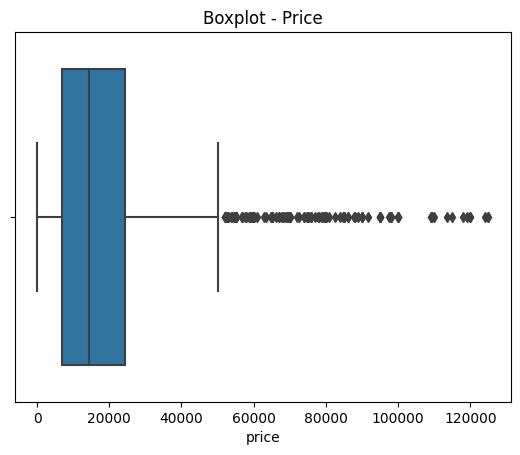

In [42]:
import seaborn as sns

sns.boxplot(x=filtered_df['price'])
plt.title('Boxplot - Price')
plt.show()

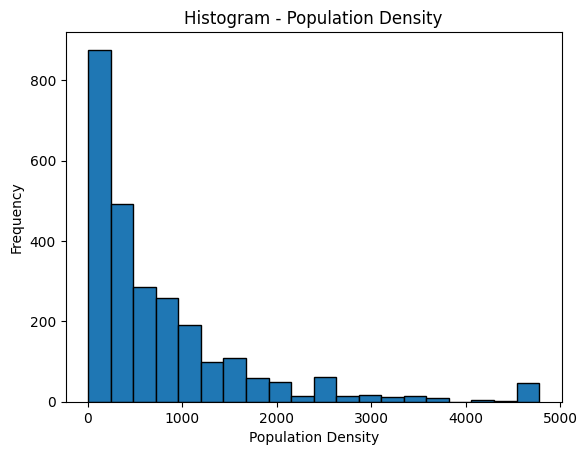

In [43]:
plt.hist(filtered_df['pop_dens'], bins=20, edgecolor='black')
plt.title('Histogram - Population Density')
plt.xlabel('Population Density')
plt.ylabel('Frequency')
plt.show()

### Density plot  (seaborn)

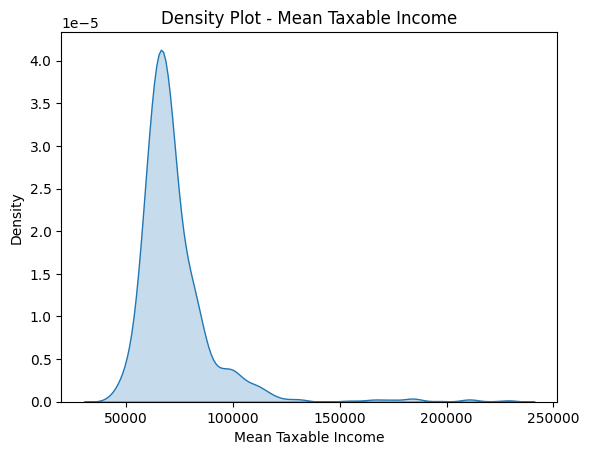

In [44]:
sns.kdeplot(filtered_df['mean_taxable_income'], fill=True)
plt.title('Density Plot - Mean Taxable Income')
plt.xlabel('Mean Taxable Income')
plt.ylabel('Density')
plt.show()

### Quantile-Quantile (QQ-) plot

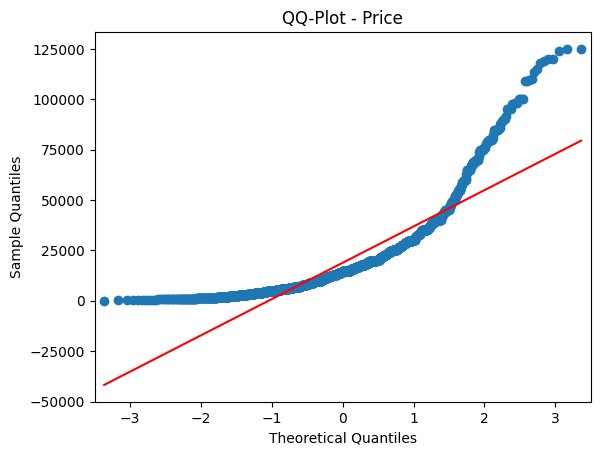

In [45]:
import statsmodels.api as sm

# Beispiel für einen QQ-Plot für die 'price'-Spalte
sm.qqplot(filtered_df['price'], line='s')
plt.title('QQ-Plot - Price')
plt.show()

## Multivariate graphical exploratory data analysis (EDA)

### Scatter plot popdens_price

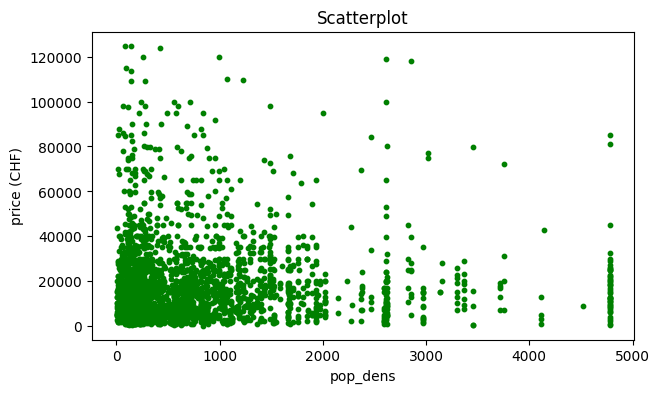

In [46]:
plt.figure(figsize=(7,4))
plt.scatter(filtered_df['pop_dens'], 
           filtered_df['price'], 
           color="green", 
           alpha=1.0,
           s=10)
plt.title('Scatterplot', fontsize=12)
plt.xlabel('pop_dens')
plt.ylabel('price (CHF)')
plt.show()


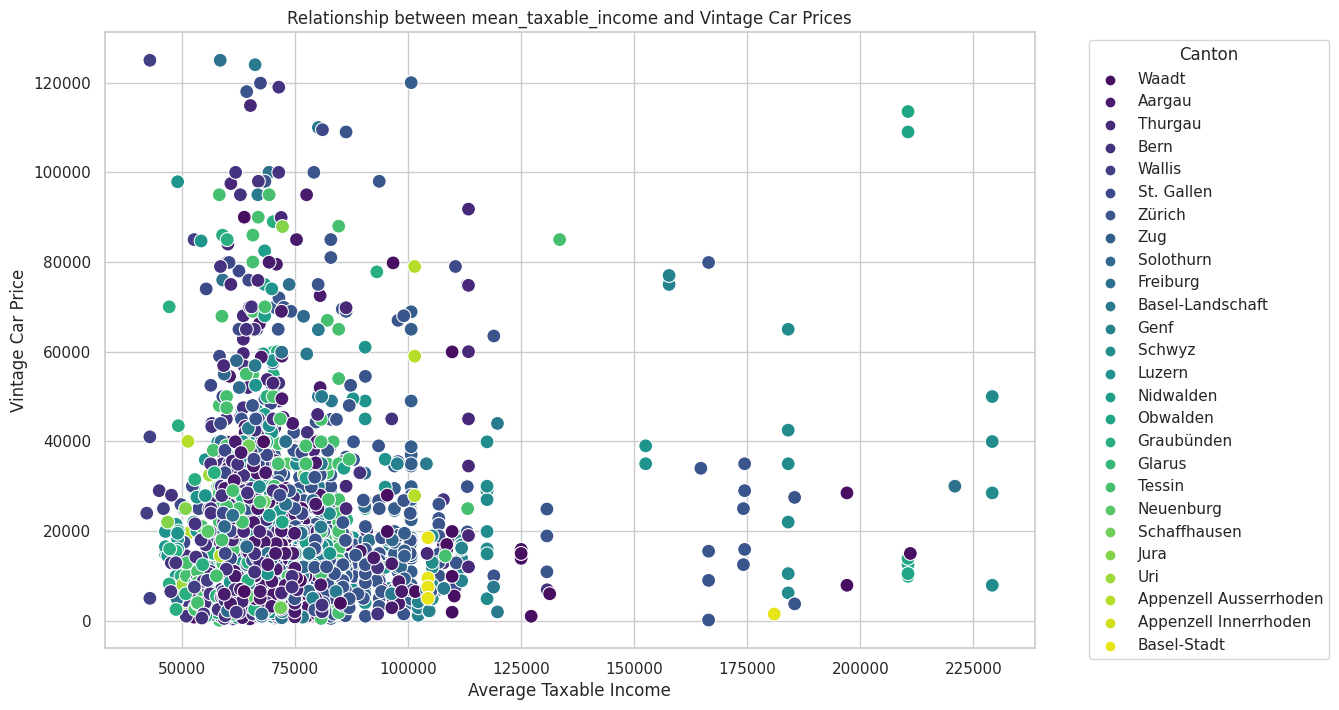

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Create scatter plot
scatterplot = sns.scatterplot(x='mean_taxable_income', y='price', data=filtered_df, hue='canton', palette='viridis', s=100)

# Adjust the plot
scatterplot.set_title('Relationship between mean_taxable_income and Vintage Car Prices')
scatterplot.set_xlabel('Average Taxable Income')
scatterplot.set_ylabel('Vintage Car Price')

# Add legend
plt.legend(title='Canton', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()


## Create new categorical variable 'price_cat'

In [48]:
# Create labels
labels = ['0 - 1000', '1001 - 10000', '10001 - 50000', '50001 - 100000', '>= 100001']

# Create new categorical variable
df_filtered["price_cat"] = pd.cut(df_filtered['price'], bins=[0, 1001, 10001, 50001, 100001, 180000], labels=labels)

# Check values
df_filtered[['price', 'price_cat']].head(10)

,price,price_cat
0,3900.0,1001 - 10000
1,5990.0,1001 - 10000
2,5990.0,1001 - 10000
3,6990.0,1001 - 10000
4,4990.0,1001 - 10000
5,3990.0,1001 - 10000
6,24200.0,10001 - 50000
7,13000.0,10001 - 50000
8,6950.0,1001 - 10000
9,4800.0,1001 - 10000


## Create a contingency table with the number of sold oldtimers per 'canton' versus 'price_cat'

In [59]:
# Contingency table (numbers in the table are apartments)
tab = pd.pivot_table(df_filtered[['price', 'canton', 'price_cat']],
                     index=['canton'],
                     columns=['price_cat'], 
                     aggfunc='count')
tab

price                                            \
price_cat              0 - 1000 1001 - 10000 10001 - 50000 50001 - 100000   
canton                                                                      
Aargau                        6          106           154             11   
Appenzell Ausserrhoden        0            9            16              2   
Appenzell Innerrhoden         0            2             2              0   
Basel-Landschaft              4           36            47              4   
Basel-Stadt                   0            4             1              0   
Bern                          6          128           163             15   
Freiburg                      4           31            29              4   
Genf                          1           21            19              2   
Glarus                        0           10             9              0   
Graubünden                    2           35            40              8   
Jura                          0           10             4              1   
Luzern                        2           43            90              8   
Neuenburg                     0            5             3              0   
Nidwalden                     0            1            11              3   
Obwalden                      1           13            17              0   
Schaffhausen                  0           19            14              1   
Schwyz                        3           18            67              2   
Solothurn                     1           39            71              4   
St. Gallen                    2           73           117             10   
Tessin                        2           73           109             16   
Thurgau                       3           59           112             16   
Uri                           0            1            12              0   
Waadt                         2           30            34              3   
Wallis                        1           33            24              1   
Zug                           0            9            41              3   
Zürich                        6          140           265             20   

                                  
price_cat              >= 100001  
canton                            
Aargau                         2  
Appenzell Ausserrhoden         0  
Appenzell Innerrhoden          0  
Basel-Landschaft               2  
Basel-Stadt                    0  
Bern                           1  
Freiburg                       3  
Genf                           0  
Glarus                         0  
Graubünden                     1  
Jura                           0  
Luzern                         0  
Neuenburg                      0  
Nidwalden                      0  
Obwalden                       2  
Schaffhausen                   0  
Schwyz                         0  
Solothurn                      1  
St. Gallen                     2  
Tessin                         2  
Thurgau                        1  
Uri                            0  
Waadt                          0  
Wallis                         1  
Zug                            1  
Zürich                         6

## Perform a Chi-square test on the cars table

In [71]:
# 1-alpha
prob = 0.95

# Chi-squared test
stat, p, dof, expected = chi2_contingency(tab)

# Critical value
critical = chi2.ppf(prob, dof)

# Print results of the Chi-square test
print('Expected frequencies:', '\n', expected.round(1), '\n')
print('Critical value:', critical.round(4), '\n')
print('Test statistic:', stat.round(4), '\n')
print('Degrees of freedom:', dof, '\n')
print(f'p-value: {p:.4f}')

Expected frequencies: 
 [[4.900e+00 1.008e+02 1.564e+02 1.420e+01 2.700e+00]
 [5.000e-01 9.800e+00 1.510e+01 1.400e+00 3.000e-01]
 [1.000e-01 1.400e+00 2.200e+00 2.000e-01 0.000e+00]
 [1.600e+00 3.360e+01 5.210e+01 4.700e+00 9.000e-01]
 [1.000e-01 1.800e+00 2.800e+00 3.000e-01 0.000e+00]
 [5.500e+00 1.131e+02 1.755e+02 1.600e+01 3.000e+00]
 [1.200e+00 2.570e+01 3.980e+01 3.600e+00 7.000e-01]
 [8.000e-01 1.550e+01 2.410e+01 2.200e+00 4.000e-01]
 [3.000e-01 6.900e+00 1.070e+01 1.000e+00 2.000e-01]
 [1.500e+00 3.110e+01 4.820e+01 4.400e+00 8.000e-01]
 [3.000e-01 5.400e+00 8.400e+00 8.000e-01 1.000e-01]
 [2.500e+00 5.170e+01 8.020e+01 7.300e+00 1.400e+00]
 [1.000e-01 2.900e+00 4.500e+00 4.000e-01 1.000e-01]
 [3.000e-01 5.400e+00 8.400e+00 8.000e-01 1.000e-01]
 [6.000e-01 1.190e+01 1.850e+01 1.700e+00 3.000e-01]
 [6.000e-01 1.230e+01 1.910e+01 1.700e+00 3.000e-01]
 [1.600e+00 3.250e+01 5.050e+01 4.600e+00 9.000e-01]
 [2.000e+00 4.190e+01 6.500e+01 5.900e+00 1.100e+00]
 [3.600e+00 7.370e+01 

### Close DB connection

In [ ]:
conn.close()

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [ ]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.2.0-1018-azure
Datetime: 2024-01-06 21:59:35
Python Version: 3.10.12
-----------------------------------
